In [2]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 15, 15
from itertools import *
import functools

In [3]:
import pandas as pd
import numpy as np

In [4]:
import nltk
import gensim
import gensim.models.doc2vec as doc2vec

In [5]:
corpus_path = "../../Corpus/serialised/hansard_1998_2012.csv"
corpus = pd.read_csv(corpus_path, index_col=0)

corpus.loc[pd.isnull(corpus.party),"party"]=""
corpus.loc[pd.isnull(corpus.debate_title),"debate_title"]=""
corpus["speech_length"] = corpus.text.str.split().apply(len)

corpus

,date,debate_type,debate_title,name,electorate,party,ingov,first_speech,text,metaparty,prime_minister,opposition_leader,speech_length
0,2011-09-14,BILLS,BILLS,"Abbott, Tony, MP",Warringah,LP,NaN,NaN,Let us consider the record of this Prime Minis...,LNC,True,True,3345
1,2011-09-14,BILLS,BILLS,"Dreyfus, Mark, MP",Isaacs,ALP,NaN,NaN,After decades of parliamentary debate about cl...,ALP,False,False,1872
2,2011-09-14,BILLS,BILLS,"Hunt, Greg, MP",Flinders,LP,NaN,NaN,"So let us begin with the heart of the matter, ...",LNC,False,False,1704
3,2011-09-14,BILLS,BILLS,"Leigh, Andrew, MP",Fraser,ALP,NaN,NaN,One way of regarding climate change mitigation...,ALP,False,False,1715
4,2011-09-14,BILLS,BILLS,"Macfarlane, Ian, MP",Groom,LP,NaN,NaN,This is a tax which will destroy Australia's c...,LNC,False,False,2033
5,2011-09-14,BILLS,BILLS,"Neumann, Shayne, MP",Blair,ALP,NaN,NaN,So he is another sceptic. He has gone from bei...,ALP,False,False,2287
6,2011-09-14,BILLS,BILLS,"Bishop, Julie, MP",Curtin,LP,NaN,NaN,We do not simply oppose it because the Prime M...,LNC,False,False,1962
7,2011-09-14,BILLS,BILLS,"Perrett, Graham, MP",Moreton,ALP,NaN,NaN,As the largest polluter per person in the worl...,ALP,False,False,1465
8,2011-09-14,BILLS,BILLS,"Ruddock, Philip, MP",Berowra,LP,NaN,NaN,I am strongly of the view that Australia shoul...,LNC,False,False,1616
9,2011-09-14,BILLS,BILLS,"Crean, Simon, MP",Hotham,ALP,NaN,NaN,Those successes that I talk about all came fro...,ALP,False,True,1710


In [9]:
tokenized_docs = list(map(nltk.word_tokenize,map(str.lower, corpus.text)))
#docs = list(map(lambda case: doc2vec.TaggedDocument(*case),
#                zip(tokenized_docs, map(lambda i: (i,),corpus.index))))

In [10]:
import pickle
with open("hansard_texts.pickle", "bw") as fh:
    pickle.dump(tokenized_docs, fh)
   
#tokenized_docs = None
#with open("hansard_texts.pickle", "br") as fh:
#    tokenized_docs = pickle.load(fh)

In [ ]:
model = doc2vec.Doc2Vec(docs,
        size=300, 
        alpha=0.025,
        window=8, 
        min_count=5,
        sample=0,
        workers=12,
        min_alpha=0.0001,
        dm=1,
        hs=1,
        negative=5,
        dm_mean=0)


In [ ]:
model = None
import pickle
with open("hansard_model.pickle", "br") as model_fs:
    model = pickle.load(model_fs)
    #pickle.dump(model, model_fs)
corpus["embeddings"]= list(model.docvecs)

In [ ]:
model_wiki = None

with open("../SemanticVsSyntacticEval/wiki_model.pickle", "br") as model_fs:
    model_wiki = pickle.load(model_fs)
corpus["embeddings"]= list(map(lambda doc: model_wiki.infer_vector(doc.words), docs))

In [11]:
ind2word = gensim.corpora.Dictionary.from_documents(tokenized_docs)
doc_bows = [ind2word.doc2bow(doc) for doc in tokenized_docs]
lda = gensim.models.LdaModel(doc_bows, id2word=ind2word, num_topics=300)



NameError: name 'lsi' is not defined

In [12]:

lda_vecs = list(map(lambda xi: list(zip(*xi))[1],lda[doc_bows]))
corpus["embeddings"]=list(map(np.asarray, lda_vecs))

In [22]:
def desparse(list_of_tuples, max_len = 300):
    ret = np.zeros(max_len)
    for index, value in list_of_tuples:
        ret[index] = value
    return ret
    
lda_vecs = [desparse(lda[doc_bows[0]]) for ii in range(len(doc_bows))]

In [23]:
corpus["embeddings"]=lda_vecs

In [24]:
X= np.row_stack(corpus.embeddings)
np.save("phrase_embeddings_lda.npy",X)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
corpus_sample = corpus.sample(1000)
corpus_sample

#pca = PCA(50)
X_sample_pca = pca.fit_transform(np.row_stack(corpus_sample.embeddings))


tsne = TSNE(n_components=2,
     perplexity=30.0,
     early_exaggeration=4.0,
     learning_rate=1000.0,
     n_iter=1000,
     metric='euclidean',
     init='random',
     verbose=10,
     random_state=None)
Y = tsne.fit_transform(X_sample_pca)

In [25]:
from sklearn.decomposition import PCA
pca = PCA(10)
Y = pca.fit_transform(X)

In [47]:
import matplotlib.cm as cm
lbls = corpus.text.str.len()
#lbls = corpus.date
##lbls = corpus.electorate
#lbls = corpus.debate_title


sorted_unique_lbls = np.unique(lbls)
try:
    sorted_unique_lbls.sort()
except:
    pass
color_names = cm.rainbow(np.linspace(0, 1, len(sorted_unique_lbls)))
color_dict = dict(zip(sorted_unique_lbls, color_names))
colors = [color_dict[lbl] for lbl in lbls]

In [38]:
lbls = functools.reduce(np.logical_or,[
    corpus.text.str.contains("defense"),
    corpus.text.str.contains("Defense"),
    corpus.text.str.contains("arm"),
    corpus.text.str.contains("Arm"),
    corpus.text.str.contains("Airforce"),
    corpus.text.str.contains("navy"),
    corpus.text.str.contains("Navy"),
    corpus.text.str.contains("war "),
    corpus.text.str.contains("War "),
    ]
)

In [ ]:
lbls = functools.reduce(np.logical_or,[
    corpus.text.str.contains("budget"),
    corpus.text.str.contains("Budget"),
    corpus.text.str.contains("cost"),
    corpus.text.str.contains("Cost")])

In [ ]:
lbls = functools.reduce(np.logical_or,[
    corpus.text.str.contains("policy"),
    corpus.text.str.contains("Policy"),
    corpus.text.str.contains("reform"),
    corpus.text.str.contains("Reform"),
    ])

In [ ]:
lbls = functools.reduce(np.logical_or,[
    corpus.text.str.contains("America"),
    corpus.text.str.contains("USA"),
    corpus.text.str.contains("US"),
    corpus.text.str.contains("U.S.A"),
    corpus.text.str.contains("U.S"),
    corpus.text.str.contains("United States")
    ])

In [ ]:
lbls = functools.reduce(np.logical_or,[
    corpus.text.str.contains("people"),
    
    ])

In [43]:
from matplotlib import colors as mpl_colors
from collections import Counter
import random
color_names = [
    'aqua','black','blue','brown','cadetblue','chartreuse','chocolate','coral','crimson','cyan','darkblue','darkcyan','darkgray','darkgreen','darkgrey','darkkhaki','darkolivegreen','darkorange','darkred','darksage','darksalmon','darkseagreen','darkslateblue','darkturquoise','darkviolet','deeppink','deepskyblue','dimgrey','dodgerblue','firebrick','forestgreen','fuchsia','gold','goldenrod','green','greenyellow','grey','hotpink','indigo','lawngreen','lime','limegreen','magenta','maroon','midnightblue','olive','orange','orangered','orchid','peru','pink','plum','purple','red','rosybrown','royalblue','salmon','sandybrown','sienna','silver', 'steelblue','tan','thistle','tomato','violet','wheat','yellow','yellowgreen',
    ]
#random.shuffle(color_names)
#lbls = corpus.debate_type

lbls = corpus.metaparty
#lbls = corpus.party
#lbls = corpus.opposition_leader
#lbls = corpus.prime_minister
#lbls = corpus.ingov
#lbls = corpus.first_speech
color_dict = dict(zip(np.unique(lbls), color_names))
colors = [color_dict[lbl] for lbl in lbls]


for name, count in Counter(lbls).most_common():
    print("%i: \t %s - %s" % (count, name, color_dict[name]))


35055: 	 ALP - aqua
33677: 	 LNC - black
3305: 	 OTHER - blue


In [52]:
corpus.date.max()

'2012-08-23'

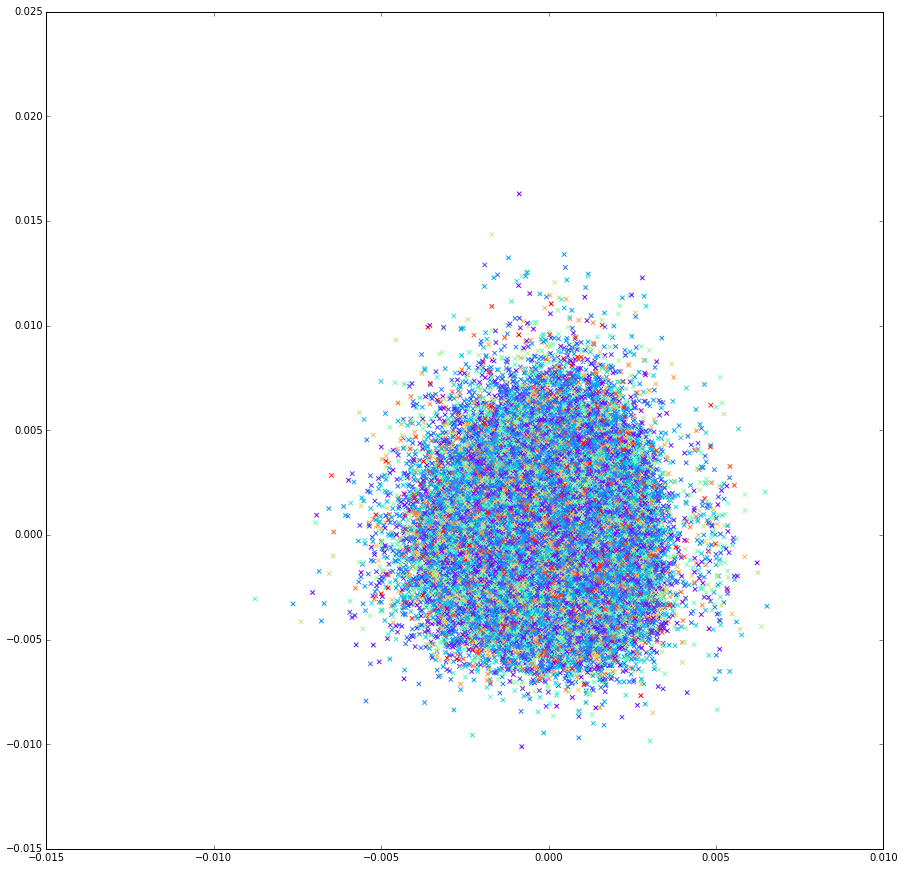

In [49]:
pl.scatter(x=Y[:,1],y=Y[:,0], c=colors, marker="x")

In [ ]:
def appro_eq(xs, value, epsilon):
    return np.logical_and(value-epsilon<xs, xs<value+epsilon ).nonzero()

In [ ]:
l

In [ ]:
lbls=np.asarray([False]*len(corpus))
zone = np.asarray(list(set(*appro_eq(Y[:,1],-0.25,0.05)).intersection(set(*appro_eq(Y[:,0],-0.1,0.05)))))
lbls[zone]=True


In [ ]:
pd.set_option("display.max_colwidth",200)

In [ ]:
corpus.loc[lbls,:]

In [ ]:
import matplotlib
matplotlib.interactive(True)

from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(xs=Y[:,0],ys=Y[:,1],zs=Y[:,2], c=colors)


In [ ]:
 test_data

In [ ]:
def multisplit(n_splits, labels, data):
    remaining_data = data
    remaining_labels = labels
    for ii in range(n_splits-1):
        ratio = 1/(n_splits-ii)
        splitter=StratifiedShuffleSplit(remaining_labels, 1, test_size=ratio, random_state=None)
        remaining_indexes, returning_indexes = list(*splitter)
        returning_data = remaining_data[returning_indexes]
        returning_labels = remaining_labels[returning_indexes]
        remaining_data = remaining_data[remaining_indexes]
        remaining_labels = remaining_labels[remaining_indexes]
        yield returning_data, returning_labels
        
    yield remaining_data,remaining_labels

    

class voting_multi_SVC:
    def __init__(self, n_svcs):
        self.svcs = [SVC(class_weight="auto",  max_iter=1000) for ii in range(n_svcs)]
    
    def fit(self, full_train_data, full_train_labels):
        for (svc,(train_data,train_labels)) in zip(self.svcs, multisplit(len(self.svcs), full_train_labels,full_train_data )):
            svc.fit(train_data,train_labels)
    
    def predict(self, data):
        from scipy.stats import mode
        #TODO, This shold shuffle every prediction, eg with np.random.permutation(range(len(self.svcs)))
        return mode(np.asarray([svc.predict(data) for svc in self.svcs]),axis=0)[0].squeeze()
            
            
            

In [ ]:
from sklearn.cross_validation import StratifiedShuffleSplit

label_name = "debate_type"
common_corpus= corpus[corpus.groupby(label_name)[label_name].transform(len)>=100]

splitter=StratifiedShuffleSplit(common_corpus[label_name].tolist(), 1, test_size=0.2, random_state=None)
train_indexes,test_indexes = list(*splitter)
test_data = common_corpus.iloc[test_indexes,:]
train_data = common_corpus.iloc[train_indexes,:]

print(len(train_data))
print(len(test_data))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_X = scaler.fit_transform(np.row_stack(train_data.embeddings))
test_data_X = scaler.transform(np.row_stack(test_data.embeddings))

In [ ]:
svc = voting_multi_SVC(10)
svc.fit(train_data_X, train_data.loc[:,label_name].as_matrix())

In [ ]:
from sklearn.svm import NuSVC, SVC, LinearSVC
#class_weight = {key: 1/value for (key, value) in Counter(training_data.debate_type).items()}
svm = LinearSVC(class_weight="auto",  max_iter=200)
svm.fit(train_data_X, train_data.loc[:, label_name])

In [ ]:
from sklearn.metrics import confusion_matrix
labels = np.unique(train_data.loc[:, label_name])
train_pred  = svm.predict(train_data_X)
train_confuse_mat = confusion_matrix(train_data.loc[:, label_name], train_pred, labels)

test_pred  = svm.predict(test_data_X)
test_confuse_mat = confusion_matrix(test_data.loc[:, label_name], test_pred, labels)

In [ ]:
def precision(confusion_mat):
    return confusion_mat.diagonal()/confusion_mat.sum(axis=0).flatten()

def recall(confusion_mat):
    return confusion_mat.diagonal()/confusion_mat.sum(axis=1).flatten()
    
def f_score(confusion_mat):
    prec = precision(confusion_mat)
    rec = recall(confusion_mat)
    return 2*prec*rec/(prec+rec)

In [ ]:
list(zip(f_score(test_confuse_mat), precision(test_confuse_mat), recall(test_confuse_mat), labels
        ))

In [ ]:


def plot_confusion_matrix(confuse_mat, labels, title='Confusion matrix', cmap=pl.cm.jet):
    pl.imshow(confuse_mat, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(labels))
    pl.xticks(tick_marks, labels, rotation=45)
    pl.yticks(tick_marks, labels)
    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')
    
def percent_confusion_matrix(confuse_mat):
    return (confuse_mat.T/confuse_mat.sum(axis=1)*100.0).T

plot_confusion_matrix(percent_confusion_matrix(test_confuse_mat),labels)

In [ ]:
plot_confusion_matrix(percent_confusion_matrix(test_confuse_mat_old),labels)

In [ ]:
paraphrase_types = list(range(1,18))
import itertools 

In [ ]:
len([active_paraphrase_types for active_paraphrase_types in itertools.chain(*[(itertools.combinations(paraphrase_types, r)) for r in range(1,1+len(paraphrase_types))])])/3600